In [23]:
#いろいろインポート
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression as LR

import datetime

pd.set_option('display.width',400)#勝手に改行コードを入れられるのを防ぐ

### dateのカラムから分布や時期の基礎集計と新規変数の検討

In [24]:
#モデルスコアデータの読み込み
place='asiya'
train_df = pd.read_csv('../csv/train_{}.csv'.format(place))
train_df=train_df.drop(["Unnamed: 0"],axis=1)#csvファイルについている名無しの列を削除
train_df['date']=pd.to_datetime(train_df['date'])#文字列なのでdateを日付型に変換
display(train_df)

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_5_rank,racer_6_ID,racer_6_age,racer_6_ave_st,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com
0,2012-04-03,1160.0,1,3959,35.0,0.14,3.0,0.541,1,43.0,...,2,4037,34.0,0.19,29.0,0.396,1,47.0,3,6
1,2012-04-03,2960.0,2,3251,46.0,0.18,10.0,0.450,1,36.0,...,3,4097,30.0,0.20,1.0,0.226,1,52.0,2,3
2,2012-04-03,21490.0,3,3662,43.0,0.16,4.0,0.480,1,68.0,...,4,3925,37.0,0.22,48.0,0.336,1,66.0,2,44
3,2012-04-03,5100.0,4,4266,27.0,0.17,21.0,0.506,1,46.0,...,2,4363,27.0,0.17,38.0,0.366,1,58.0,3,62
4,2012-04-03,1980.0,5,4112,32.0,0.21,40.0,0.439,1,39.0,...,2,4573,24.0,0.15,53.0,0.514,1,75.0,4,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19337,2020-03-27,54960.0,6,3503,51.0,0.19,26.0,0.156,1,44.0,...,2,3885,46.0,0.15,20.0,0.348,1,18.0,3,83
19338,2020-03-27,650.0,8,3873,44.0,0.17,41.0,0.426,1,61.0,...,4,3694,48.0,0.17,12.0,0.200,1,29.0,2,14
19339,2020-03-27,3930.0,9,3618,47.0,0.18,8.0,0.464,0,62.0,...,3,4252,37.0,0.17,18.0,0.279,1,23.0,2,10
19340,2020-03-27,1430.0,10,3710,46.0,0.17,45.0,0.247,1,52.0,...,2,4123,39.0,0.19,35.0,0.542,0,32.0,4,25


In [25]:
#新規変数の追加（月番号(month)、num_date,range_date）
#dateの型変換したものから月、年の情報の抽出
train_df['year']=train_df['date'].dt.year
train_df['month']=train_df['date'].dt.month
train_df['day']=train_df['date'].dt.day

#何日間の大会なのか(range_date)と大会(num_date)の何日目なのかの情報を追加

num_date=1
num_date_arr=[]
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtarainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して、そのレース日番号を加算
            num_date+=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
        else:#想定していた日付でない(違う大会になった)場合はレース日をリセット
            num_date=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            
train_df['num_date']=num_date_arr
#train_df['range_date']=


In [26]:
range_races=0#大会中の取得できたレースの数
range_date=1#大会の開催日数
range_date_arr=[]
range_date_arr_2=[]#for文中で繰り返し上書きさせる用の配列
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtrainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        range_races+=1
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        #num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して終了
            range_date+=1
            range_races+=1
            last_race_date=row['date']#前回レース日を上書き
            next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日  
        else:#想定していた日付でない(違う大会になった)場合は現在のrange_dateをもとに前の大会のレースに大会開催日数を持たせる。

            range_date_arr_2=[range_date]*range_races
            for num in range_date_arr_2:
                range_date_arr.append(num)
            range_races=1#大会中の取得できたレースの数
            range_date=1#大会の開催日数
            last_race_date=row['date']#前回レース日を上書き
            next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            
            
range_date_arr_2=[range_date]*range_races#最後の日は日付の変わり絵が発生しないので特別処理
for num in range_date_arr_2:
    range_date_arr.append(num)
train_df['range_date']=range_date_arr
#train_df['range_date']=


In [27]:
#train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

分析が細かすぎるから月から四半期にスケールを大きくする。

In [30]:
#四半期カラムの作成
train_df['season']=train_df['month']
train_df['season']=train_df['season'].replace([3,4,5],'sp')#春
train_df['season']=train_df['season'].replace([6,7,8],'su')#夏
train_df['season']=train_df['season'].replace([9,10,11],'au')#秋
train_df['season']=train_df['season'].replace([12,1,2],'wi')#冬
train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

In [29]:
train_df.head()

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
0,2012-04-03,1160.0,1,3959,35.0,0.14,3.0,0.541,1,43.0,...,1,47.0,3,6,2012,4,3,1,6,sp
1,2012-04-03,2960.0,2,3251,46.0,0.18,10.0,0.450,1,36.0,...,1,52.0,2,3,2012,4,3,1,6,sp
2,2012-04-03,21490.0,3,3662,43.0,0.16,4.0,0.480,1,68.0,...,1,66.0,2,44,2012,4,3,1,6,sp
3,2012-04-03,5100.0,4,4266,27.0,0.17,21.0,0.506,1,46.0,...,1,58.0,3,62,2012,4,3,1,6,sp
4,2012-04-03,1980.0,5,4112,32.0,0.21,40.0,0.439,1,39.0,...,1,75.0,4,25,2012,4,3,1,6,sp


In [8]:
analysis_train_df=train_df[train_df['result_com']<=24]#傾向が見たいしどうせ使わないから24以下のは消す(2-1-6まで)。
analysis_train_df


,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
0,2012-04-03,1160.0,1,3959,35.0,0.14,3.0,0.541,1,43.0,...,1,47.0,3,6,2012,4,3,1,6,sp
1,2012-04-03,2960.0,2,3251,46.0,0.18,10.0,0.450,1,36.0,...,1,52.0,2,3,2012,4,3,1,6,sp
7,2012-04-03,2910.0,9,3552,41.0,0.18,12.0,0.349,1,71.0,...,1,72.0,4,8,2012,4,3,1,6,sp
9,2012-04-03,980.0,12,4296,25.0,0.17,11.0,0.536,1,33.0,...,1,55.0,4,5,2012,4,3,1,6,sp
10,2012-04-04,4480.0,1,3159,47.0,0.17,32.0,0.615,1,44.0,...,1,74.0,2,16,2012,4,4,2,6,sp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19335,2020-03-27,990.0,4,4156,39.0,0.15,40.0,0.383,1,68.0,...,1,51.0,2,9,2020,3,27,4,4,sp
19336,2020-03-27,1320.0,5,4809,31.0,0.16,38.0,0.318,1,56.0,...,1,21.0,1,2,2020,3,27,4,4,sp
19338,2020-03-27,650.0,8,3873,44.0,0.17,41.0,0.426,1,61.0,...,1,29.0,2,14,2020,3,27,4,4,sp
19339,2020-03-27,3930.0,9,3618,47.0,0.18,8.0,0.464,0,62.0,...,1,23.0,2,10,2020,3,27,4,4,sp


In [9]:
#基礎集計入りまーす(基本的な)
#年単位ざっくり
group_year_df=analysis_train_df.groupby(['year','result_com']).count()
group_year_df.to_csv('year_{}_date.csv'.format(place),encoding='utf-8')
#季節（本命）
group_season_df=analysis_train_df.groupby(['year','season','result_com']).count()
group_season_df.to_csv('season_{}_date.csv'.format(place),encoding='utf-8')
#月単位
group_month_df=analysis_train_df.groupby(['year','month','result_com']).count()
group_month_df.to_csv('month_{}_date.csv'.format(place),encoding='utf-8')

In [10]:
group_season_df.head()

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2012 au     1             24     24           24          24           24              24          24            24            24          24  ...              24          24            24            24          24            24     24   24        24          24
            2             31     31           31          31           31              31          31            31            31          31  ...              31          31            31            31          31            31     31   31        31          31
            3             18     18           18          18           18              18          18            18            18          18  ...              18          18            18            18          18            18     18   18        18          18
            4             12     12           12          12           12              12          12            12            12          12  ...              12          12            12            12          12            12     12   12        12          12
            5             21     21           21          21           21              21          21            21            21          21  ...              21          21            21            21          21            21     21   21        21          21

[5 rows x 55 columns]

In [11]:
len(group_season_df['date'].values)

861

In [12]:
len(group_season_df['date'].index.levels[0])

9

# 年単位＝結果:そこまで大きく傾向は変わっていない

In [13]:
season_df=group_season_df.loc[2015:2019, :]
season_df

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2015 au     1             47     47           47          47           47              47          47            47            47          47  ...              47          47            47            47          47            47     47   47        47          47
            2             24     24           24          24           24              24          24            24            24          24  ...              24          24            24            24          24            24     24   24        24          24
            3             28     28           28          28           28              28          28            28            28          28  ...              28          28            28            28          28            28     28   28        28          28
            4             15     15           15          15           15              15          15            15            15          15  ...              15          15            15            15          15            15     15   15        15          15
            5             22     22           22          22           22              22          22            22            22          22  ...              22          22            22            22          22            22     22   22        22          22
...                      ...    ...          ...         ...          ...             ...         ...           ...           ...         ...  ...             ...         ...           ...           ...         ...           ...    ...  ...       ...         ...
2019 wi     20             2      2            2           2            2               2           2             2             2           2  ...               2           2             2             2           2             2      2    2         2           2
            21            14     14           14          14           14              14          14            14            14          14  ...              14          14            14            14          14            14     14   14        14          14
            22            12     12           12          12           12              12          12            12            12          12  ...              12          12            12            12          12            12     12   12        12          12
            23            13     13           13          13           13              13          13            13            13          13  ...              13          13            13            13          13            13     13   13        13          13
            24             4      4            4           4            4               4           4             4             4           4  ...               4           4             4             4           4             4      4    4         4           4

[479 rows x 55 columns]

#### 2019

Text(0, 0.5, 'y axis')

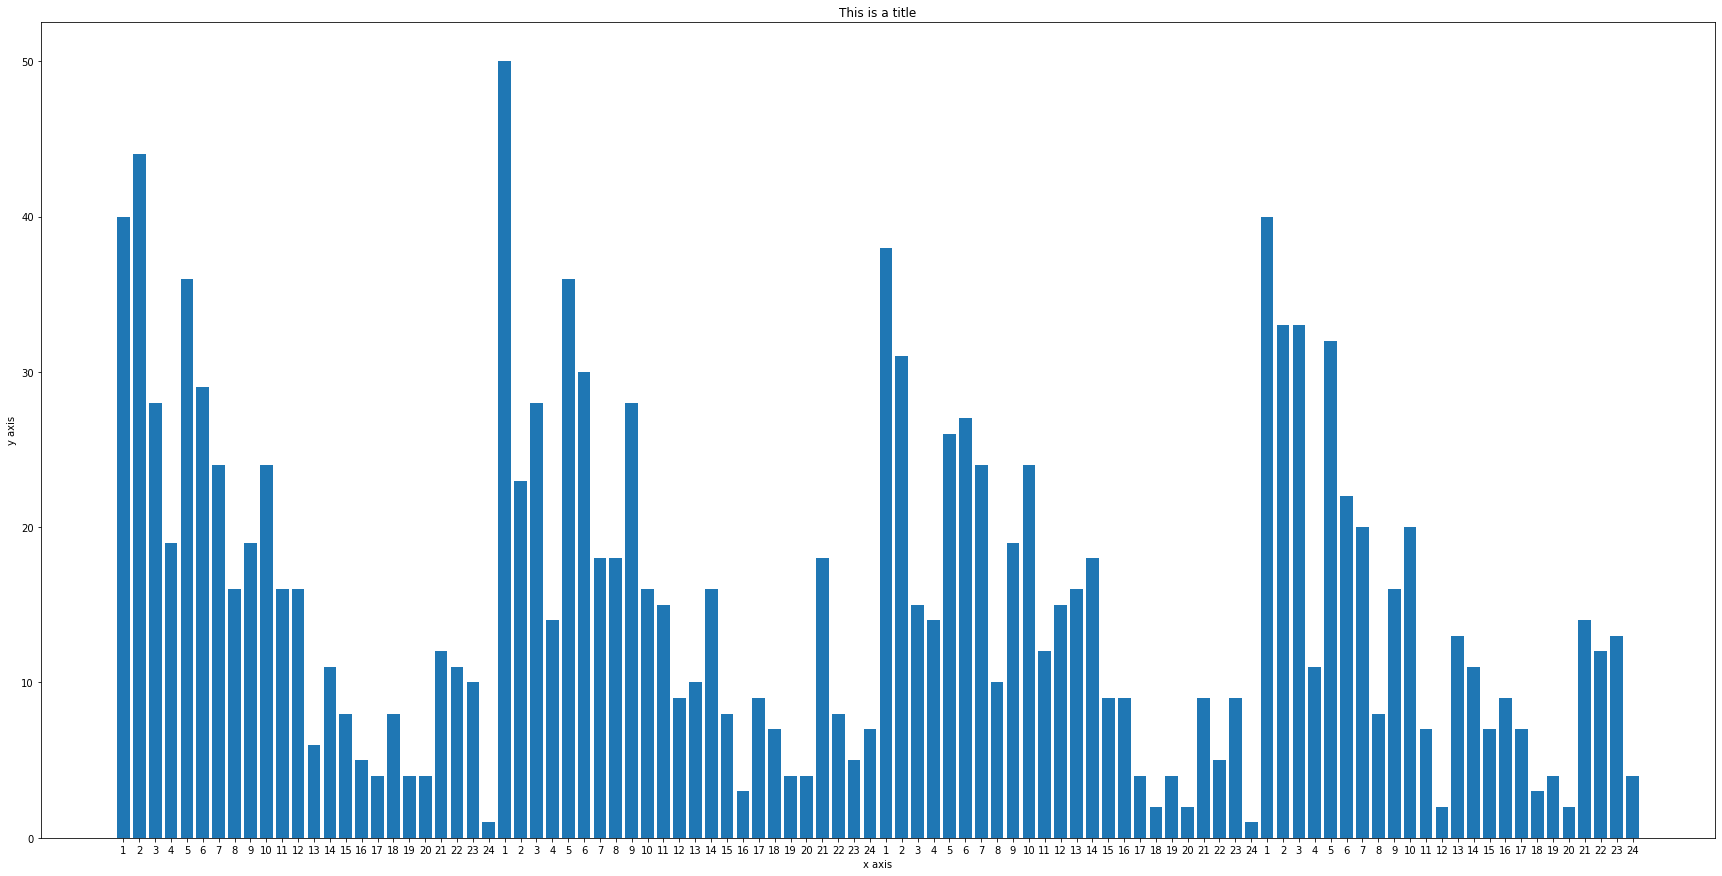

In [14]:

graph_df=season_df.loc[2019, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2018

Text(0, 0.5, 'y axis')

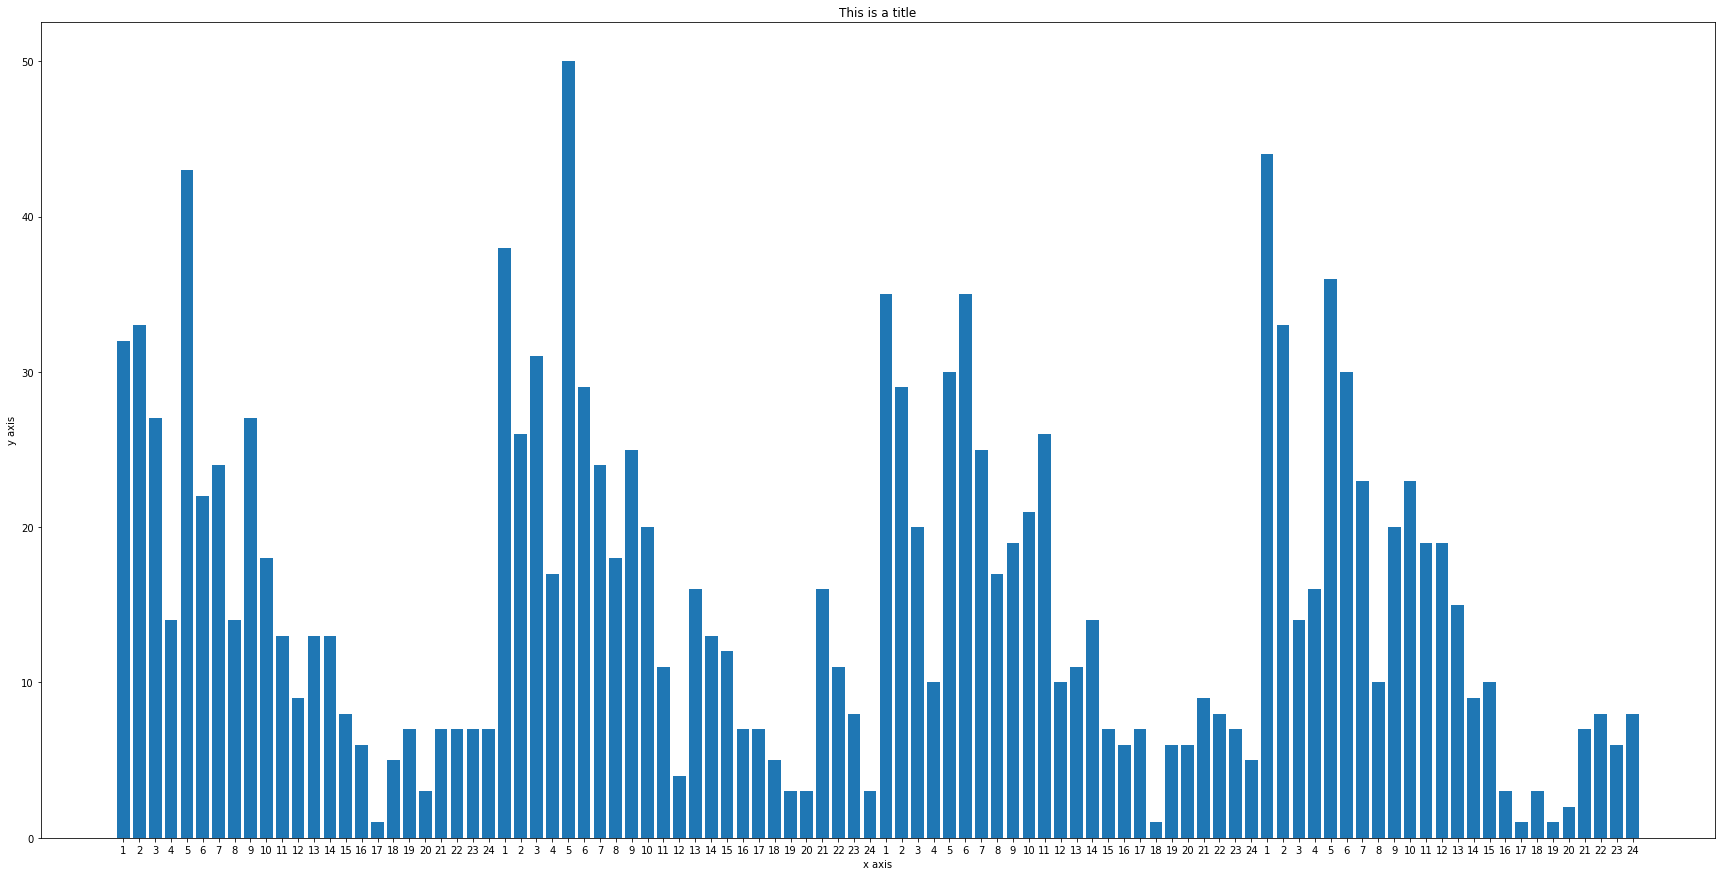

In [15]:

graph_df=season_df.loc[2018, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2017

Text(0, 0.5, 'y axis')

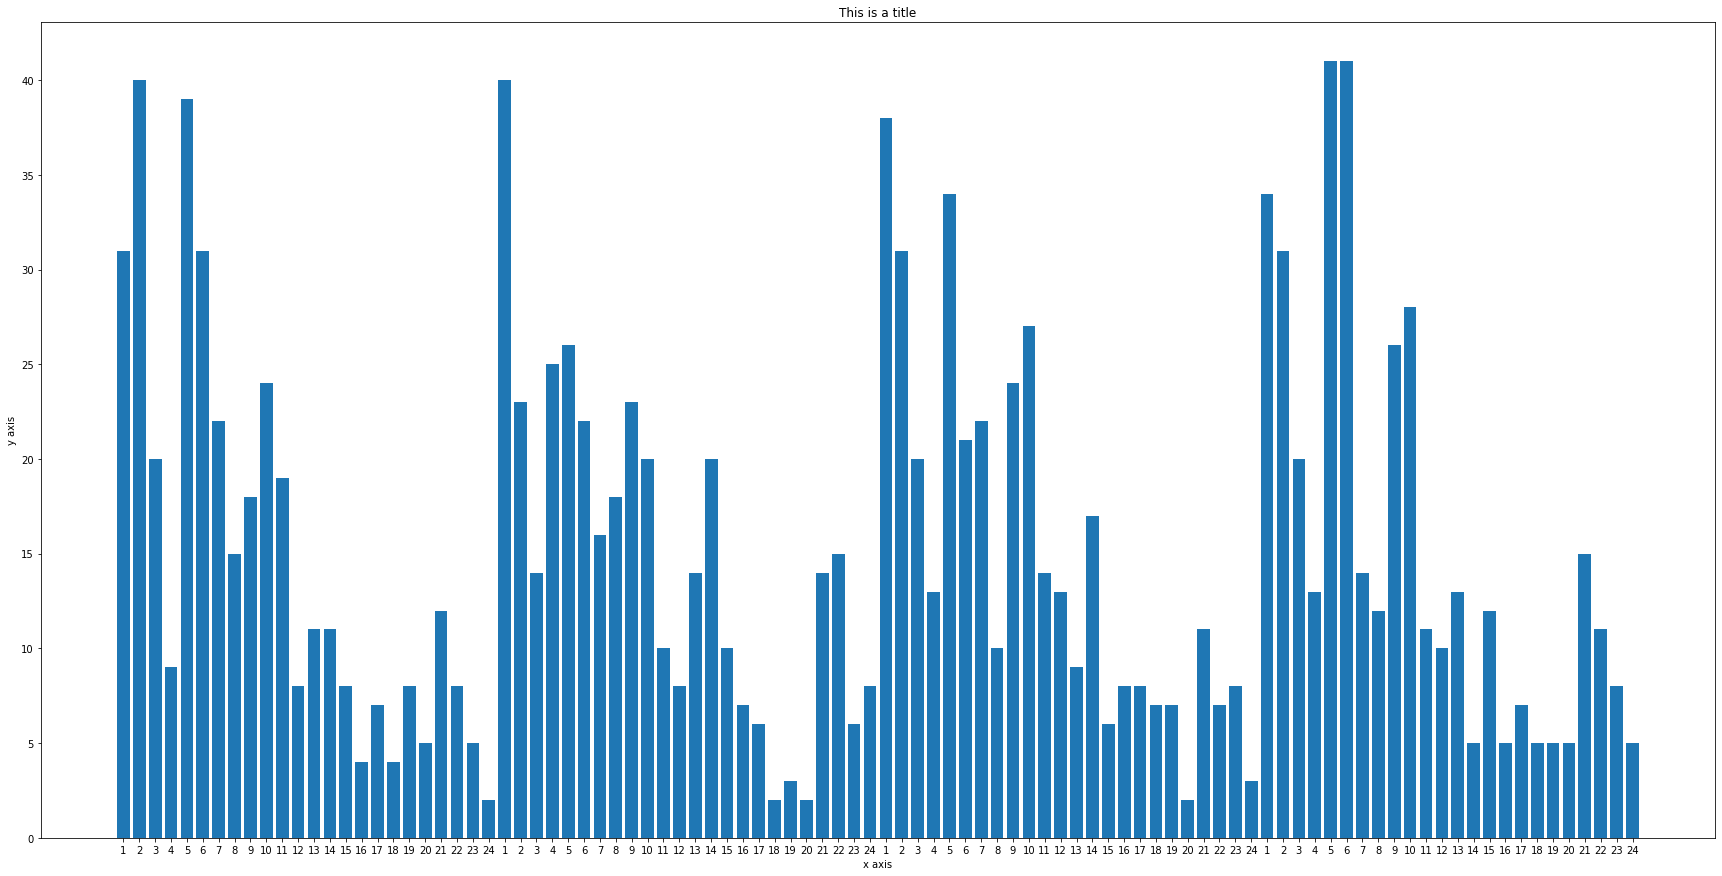

In [16]:

graph_df=season_df.loc[2017, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2015

Text(0, 0.5, 'y axis')

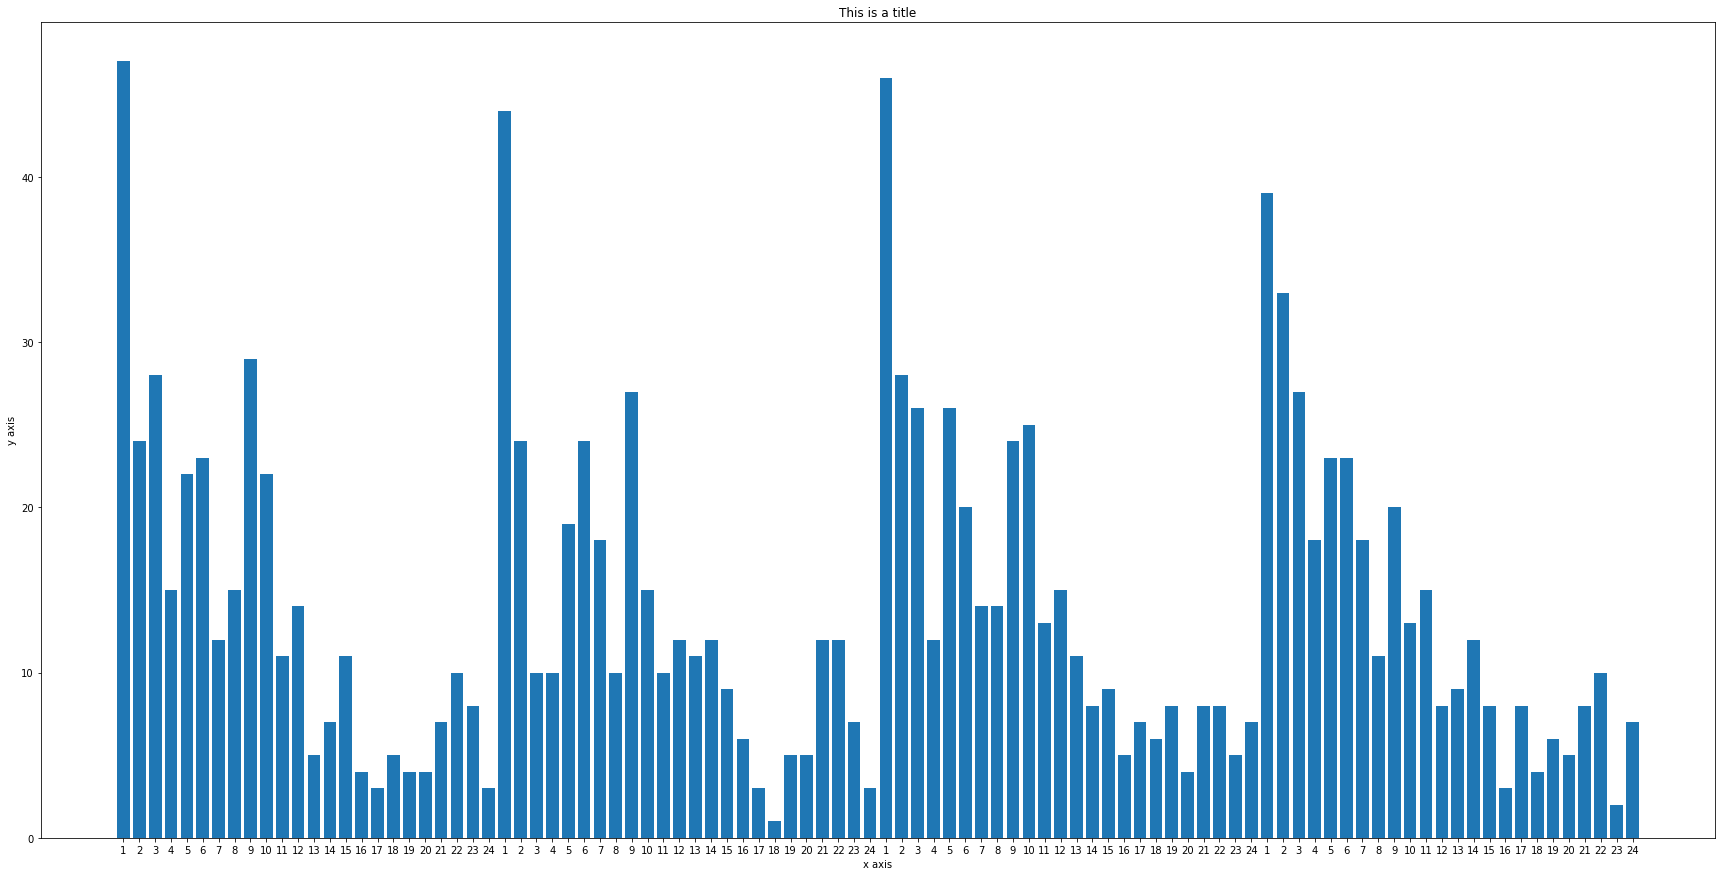

In [17]:

graph_df=season_df.loc[2015, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

# 季節　結果:

Text(0, 0.5, 'y axis')

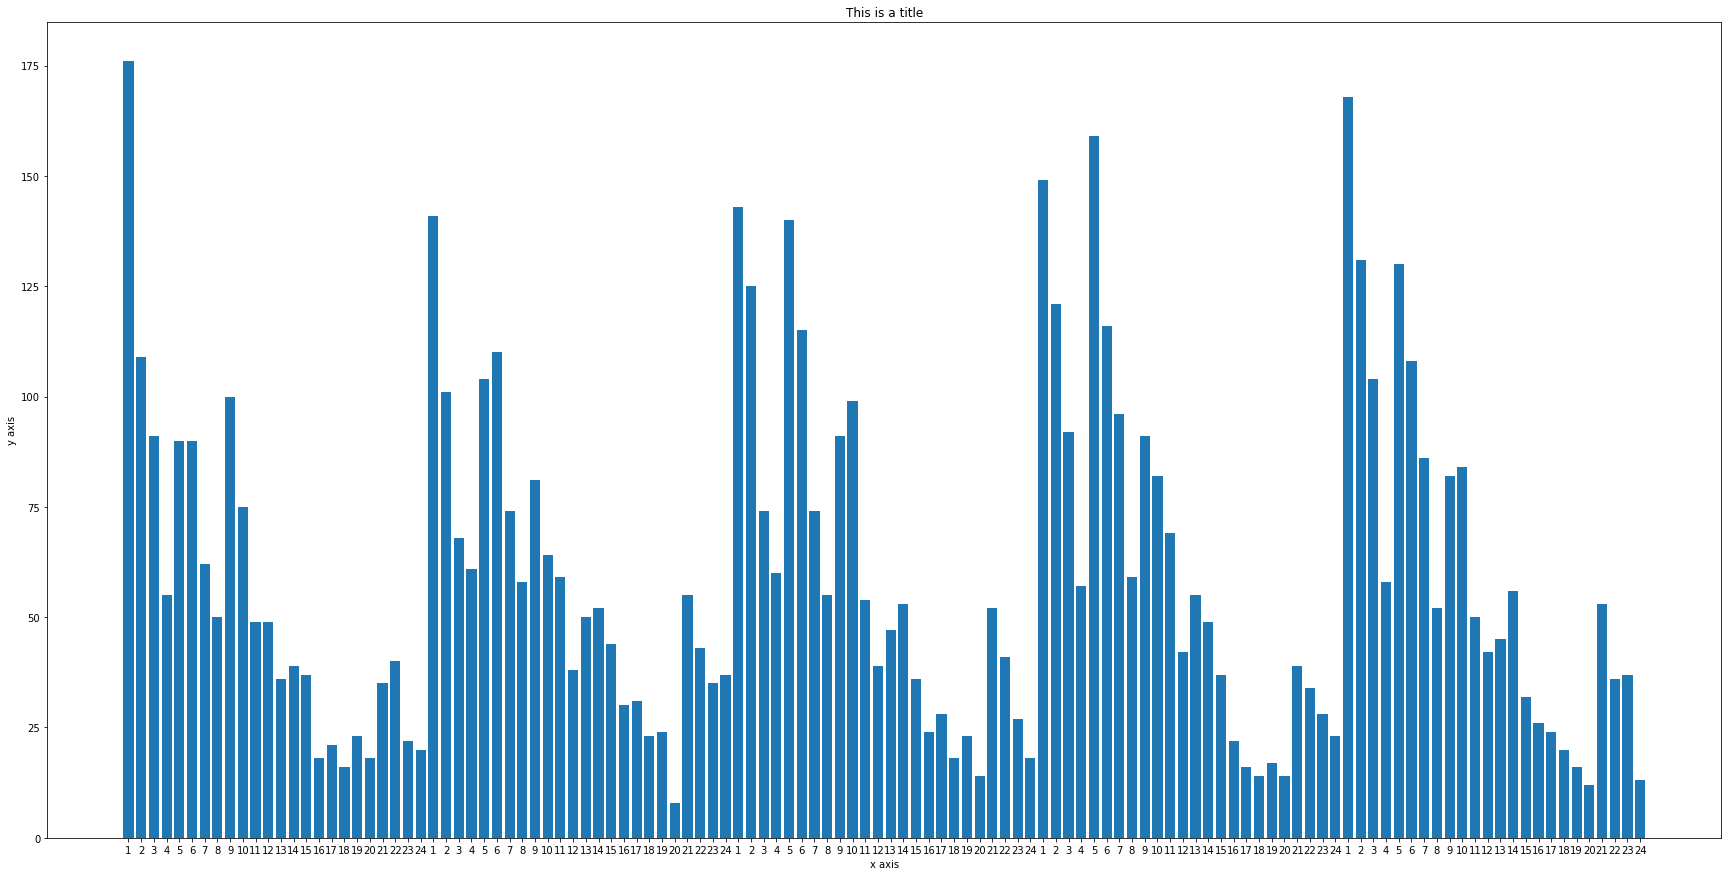

In [18]:

graph_df=group_year_df.loc[2015:2019, :]
graph_df
plt.figure(figsize=(30,15))
#Xラベル作成
x=[]
for i in range(5):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

In [19]:
group_season_df['date'].index.levels[2]

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], dtype='int64', name='result_com')

In [20]:
#train_df.to_csv('test.csv',encoding='utf-8')